In [853]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [854]:
VCB = pd.read_csv("VCB-History.csv")
# Xoá cột chỉ mục không cần thiết
df = VCB.drop(columns=['Unnamed: 0'])


# Xem lại dữ liệu sau khi xoá cột
print(df.head())


         date   open   high   low  close  volume ticker
0  2014-05-20   9960  10100  9770  10070  280870    VCB
1  2014-05-21  10100  10100  9920  10030  289340    VCB
2  2014-05-22  10030  10070  9960   9960  463230    VCB
3  2014-05-23   9960   9960  9700   9700  493560    VCB
4  2014-05-26   9810  10070  9700  10070  319920    VCB


# Tiền xử lý


In [855]:
# Hiển thị 10 dòng đầu của VCB
VCB.head(10)

,Unnamed: 0,date,open,high,low,close,volume,ticker
0,0,2014-05-20,9960,10100,9770,10070,280870,VCB
1,1,2014-05-21,10100,10100,9920,10030,289340,VCB
2,2,2014-05-22,10030,10070,9960,9960,463230,VCB
3,3,2014-05-23,9960,9960,9700,9700,493560,VCB
4,4,2014-05-26,9810,10070,9700,10070,319920,VCB
5,5,2014-05-27,10070,10510,10030,10510,482210,VCB
6,6,2014-05-28,10510,10730,10510,10660,849320,VCB
7,7,2014-05-29,10690,10770,10470,10550,360170,VCB
8,8,2014-05-30,10550,10690,10470,10690,397450,VCB
9,9,2014-06-02,10730,10730,10470,10690,306000,VCB


In [856]:
VCB['date'] = pd.to_datetime(VCB['date'])

# Định dạng lại cột 'date' theo định dạng dd-mm-yyyy
VCB['date'] = VCB['date'].dt.strftime('%d-%m-%Y')


In [857]:
VCB.describe()

,Unnamed: 0,open,high,low,close,volume
count,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000,2.499000e+03
mean,1249.000000,46123.187275,46671.665866,45599.960784,46154.400560,1.192629e+06
std,721.543484,23985.539989,24207.480603,23732.984636,23987.858631,8.177100e+05
min,0.000000,9810.000000,9960.000000,9700.000000,9700.000000,3.638000e+04
25%,624.500000,23060.000000,23300.000000,22840.000000,23050.000000,6.525200e+05
50%,1249.000000,44230.000000,45010.000000,43610.000000,44240.000000,1.005430e+06
75%,1873.500000,64935.000000,65489.000000,64059.500000,64930.000000,1.512060e+06
max,2498.000000,98500.000000,100500.000000,97300.000000,97400.000000,7.265480e+06


In [858]:
# Tính phương sai và độ lệch chuẩn cho cột 'close'
variance = VCB['close'].var()
std_deviation = VCB['close'].std()

print(f"Phương sai (Variance): {variance}")
print(f"Độ lệch chuẩn (Standard Deviation): {std_deviation}")

Phương sai (Variance): 575417361.685364
Độ lệch chuẩn (Standard Deviation): 23987.858630677394


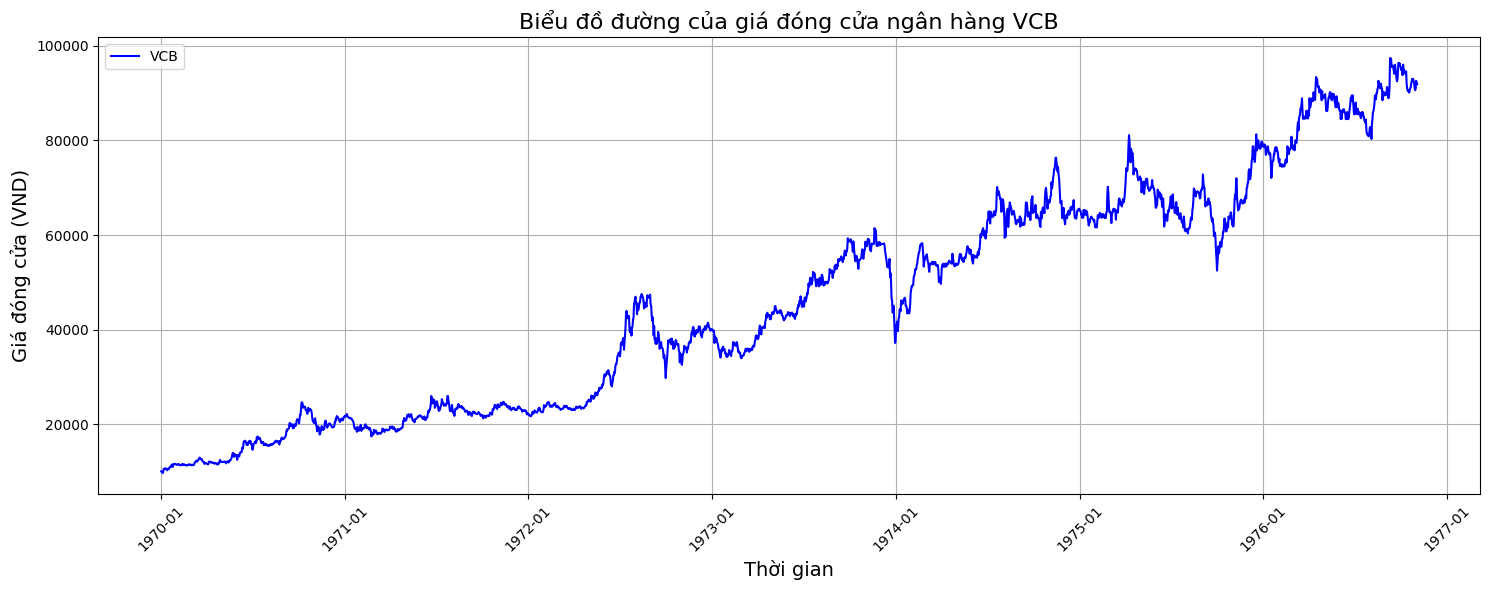

In [859]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.plot(VCB['date'], VCB['close'], label='VCB', color='blue')

plt.title('Biểu đồ đường của giá đóng cửa ngân hàng VCB', fontsize=16)
plt.xlabel('Thời gian', fontsize=14)
plt.ylabel('Giá đóng cửa (VND)', fontsize=14)

# Xử lý trục thời gian
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Tự động giãn nhãn thời gian
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Hiển thị năm-tháng

plt.xticks(rotation=45)  # Xoay trục X
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


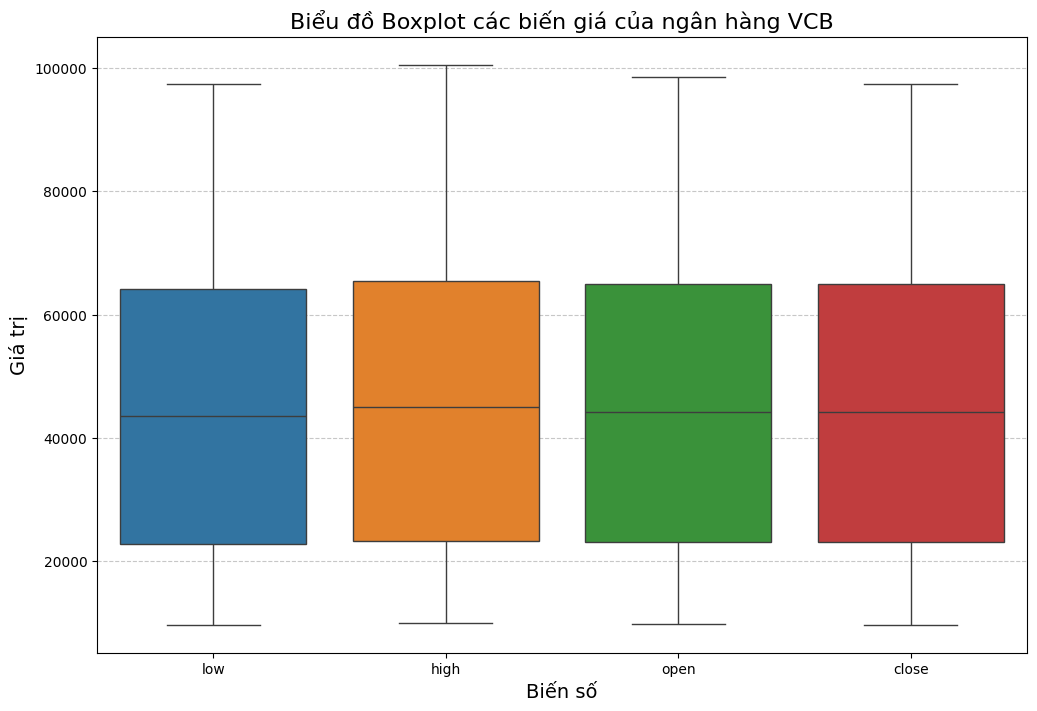

In [860]:
import seaborn as sns

import matplotlib.pyplot as plt

# Chọn các cột cần thiết
columns_to_plot = ['low', 'high', 'open', 'close']

# Vẽ biểu đồ boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=VCB[columns_to_plot])
plt.title('Biểu đồ Boxplot các biến giá của ngân hàng VCB', fontsize=16)
plt.xlabel('Biến số', fontsize=14)
plt.ylabel('Giá trị', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

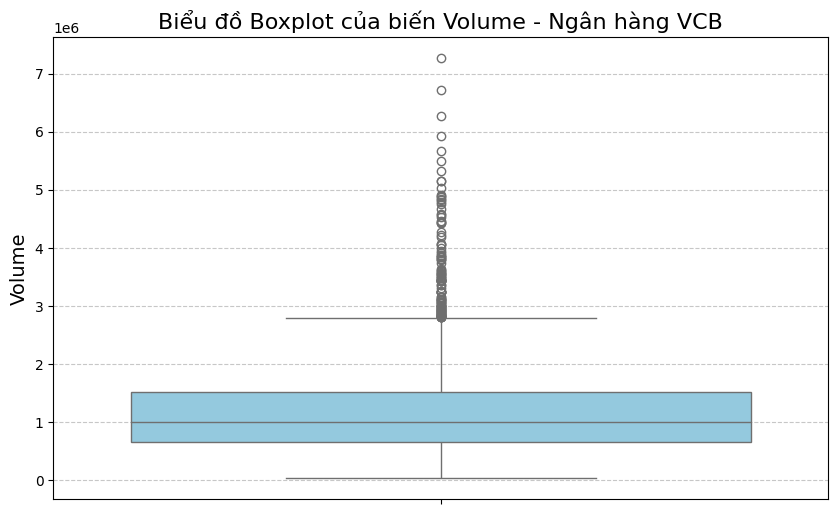

In [861]:
import seaborn as sns

import matplotlib.pyplot as plt

# Vẽ biểu đồ boxplot cho biến 'volume'
plt.figure(figsize=(10, 6))
sns.boxplot(data=VCB, y='volume', color='skyblue')
plt.title('Biểu đồ Boxplot của biến Volume - Ngân hàng VCB', fontsize=16)
plt.ylabel('Volume', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [862]:
# Tính toán IQR
Q1 = VCB['volume'].quantile(0.25)  # Phân vị thứ nhất (25%)
Q3 = VCB['volume'].quantile(0.75)  # Phân vị thứ ba (75%)
IQR = Q3 - Q1  # Khoảng tứ phân vị

# Xác định ngưỡng để tìm ngoại lai
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc các giá trị ngoại lai
outliers = VCB[(VCB['volume'] < lower_bound) | (VCB['volume'] > upper_bound)]

print("Các giá trị ngoại lai trong biến 'volume':")
print(outliers)

Các giá trị ngoại lai trong biến 'volume':
      Unnamed: 0        date   open   high    low  close   volume ticker
151          151  19-12-2014  13360  13630  12520  12520  4879410    VCB
165          165  12-01-2015  16370  16730  16239  16460  3059730    VCB
208          208  20-03-2015  15620  16110  15620  15930  4058430    VCB
333          333  18-09-2015  19900  20260  19900  19900  3095740    VCB
398          398  18-12-2015  19670  19940  18630  18630  3155650    VCB
...          ...         ...    ...    ...    ...    ...      ...    ...
1949        1949  08-03-2022  70960  71550  69010  69010  2936300    VCB
2147        2147  16-12-2022  67320  70190  66810  67490  3158100    VCB
2375        2375  15-11-2023  86500  87700  86500  87700  4067800    VCB
2444        2444  28-02-2024  91000  97400  90400  97400  4219900    VCB
2454        2454  13-03-2024  94900  96500  94300  96000  3124500    VCB

[114 rows x 8 columns]


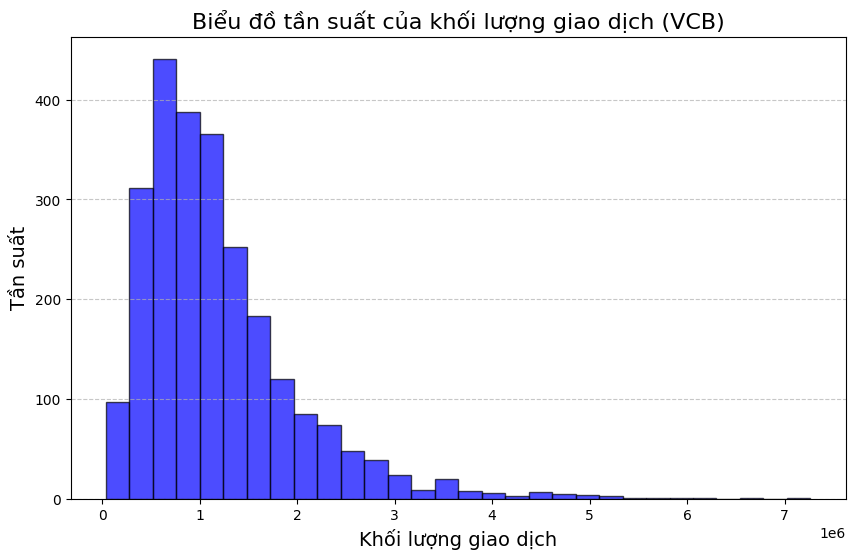

In [863]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ histogram cho biến volume
plt.figure(figsize=(10, 6))  # Thiết lập kích thước biểu đồ
plt.hist(VCB['volume'], bins=30, color='blue', alpha=0.7, edgecolor='black')  # Vẽ histogram với 30 cột, màu xanh
plt.title('Biểu đồ tần suất của khối lượng giao dịch (VCB)', fontsize=16)  # Tiêu đề biểu đồ
plt.xlabel('Khối lượng giao dịch', fontsize=14)  # Nhãn trục X
plt.ylabel('Tần suất', fontsize=14)  # Nhãn trục Y
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Thêm lưới ngang
plt.show()  # Hiển thị biểu đồ


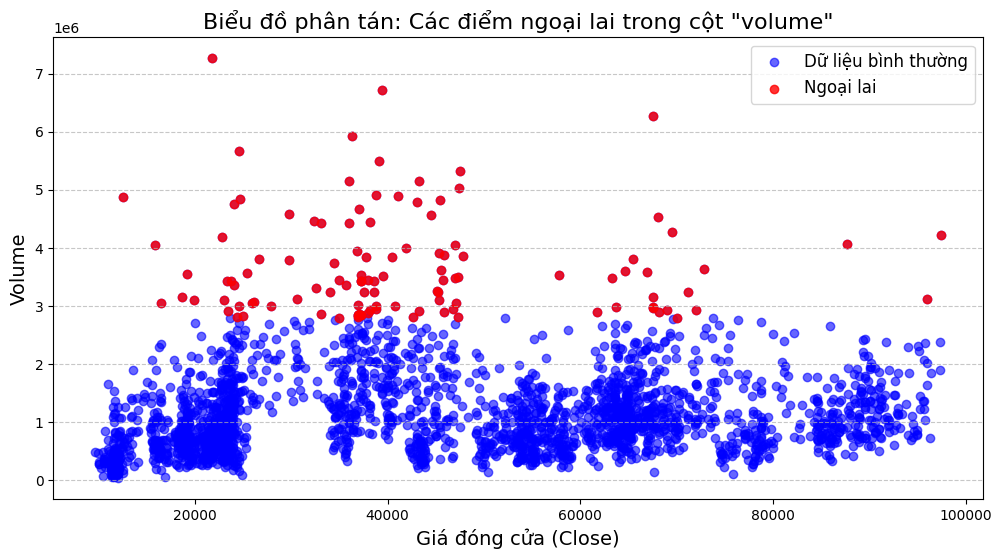

In [864]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ phân tán cho cột 'volume' và 'close'
plt.figure(figsize=(12, 6))
plt.scatter(VCB['close'], VCB['volume'], color='blue', label='Dữ liệu bình thường', alpha=0.6)
plt.scatter(outliers['close'], outliers['volume'], color='red', label='Ngoại lai', alpha=0.8)

# Thêm tiêu đề và nhãn
plt.title('Biểu đồ phân tán: Các điểm ngoại lai trong cột "volume"', fontsize=16)
plt.xlabel('Giá đóng cửa (Close)', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

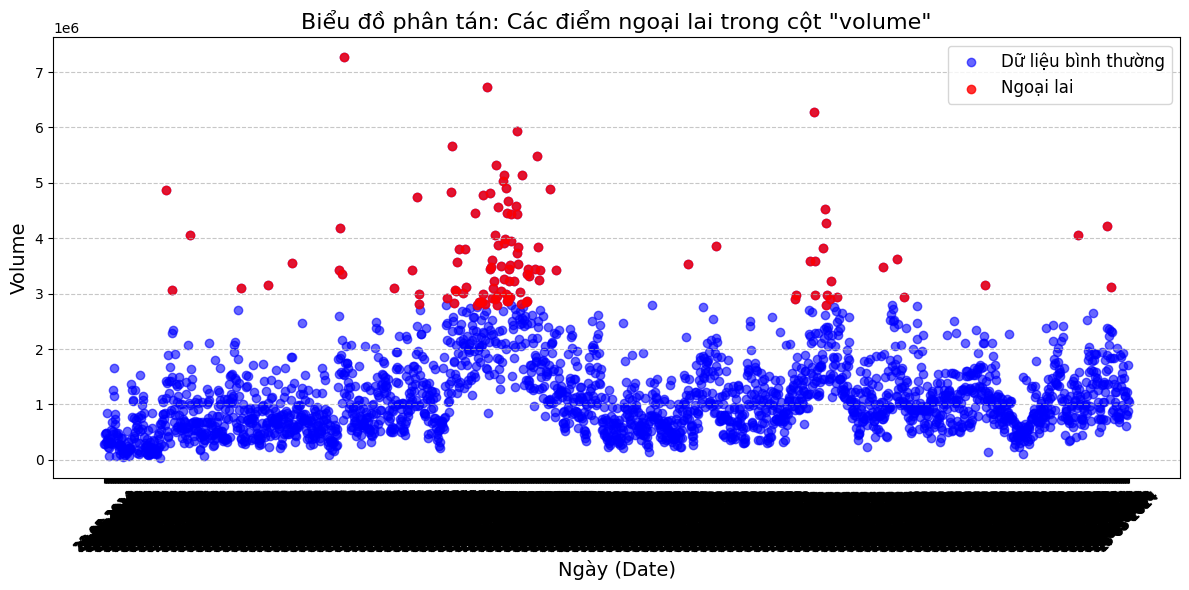

In [865]:
# Vẽ biểu đồ phân tán cho cột 'volume' và 'date'
plt.figure(figsize=(12, 6))
plt.scatter(VCB['date'], VCB['volume'], color='blue', label='Dữ liệu bình thường', alpha=0.6)
plt.scatter(outliers['date'], outliers['volume'], color='red', label='Ngoại lai', alpha=0.8)

# Thêm tiêu đề và nhãn
plt.title('Biểu đồ phân tán: Các điểm ngoại lai trong cột "volume"', fontsize=16)
plt.xlabel('Ngày (Date)', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Xoay nhãn trục X để dễ đọc
plt.tight_layout()
plt.show()

In [866]:
VCB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2499 non-null   int64 
 1   date        2499 non-null   object
 2   open        2499 non-null   int64 
 3   high        2499 non-null   int64 
 4   low         2499 non-null   int64 
 5   close       2499 non-null   int64 
 6   volume      2499 non-null   int64 
 7   ticker      2499 non-null   object
dtypes: int64(6), object(2)
memory usage: 156.3+ KB


- Dữ liệu không bị thiếu

In [867]:
print(VCB.isnull().sum())

Unnamed: 0    0
date          0
open          0
high          0
low           0
close         0
volume        0
ticker        0
dtype: int64


- Kiểm tra dữ liệu có bao nhiêu hàng, cột

In [868]:
VCB.shape

(2499, 8)

# Trực quan hóa

In [869]:
df = VCB.copy()
# Chuyển đổi cột "date" sang kiểu dữ liệu ngày tháng
# Chuyển đổi cột 'date' thành kiểu datetime nếu chưa thực hiện
df['date'] = pd.to_datetime(VCB['date'])

# Đặt cột 'date' làm chỉ mục
df.set_index('date', inplace=True)



C:\Users\Admin\AppData\Local\Temp\ipykernel_20276\3599015801.py:4: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [870]:
df

,Unnamed: 0,open,high,low,close,volume,ticker
date,,,,,,,
2014-05-20,0,9960,10100,9770,10070,280870,VCB
2014-05-21,1,10100,10100,9920,10030,289340,VCB
2014-05-22,2,10030,10070,9960,9960,463230,VCB
2014-05-23,3,9960,9960,9700,9700,493560,VCB
2014-05-26,4,9810,10070,9700,10070,319920,VCB
...,...,...,...,...,...,...,...
2024-05-14,2494,91100,91600,90500,90600,818400,VCB
2024-05-15,2495,91000,91300,90800,91000,883100,VCB
2024-05-16,2496,92000,92700,91500,92600,1713900,VCB


<Figure size 1200x800 with 0 Axes>

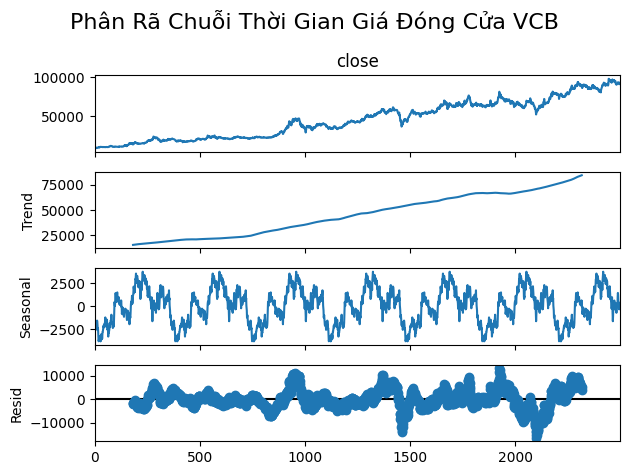

In [871]:
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt


# Thực hiện phân rã chuỗi thời gian
result = seasonal_decompose(VCB['close'], model='additive', period=365)

# Vẽ đồ thị phân rã
plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('Phân Rã Chuỗi Thời Gian Giá Đóng Cửa VCB', fontsize=16)
plt.tight_layout()
plt.show()

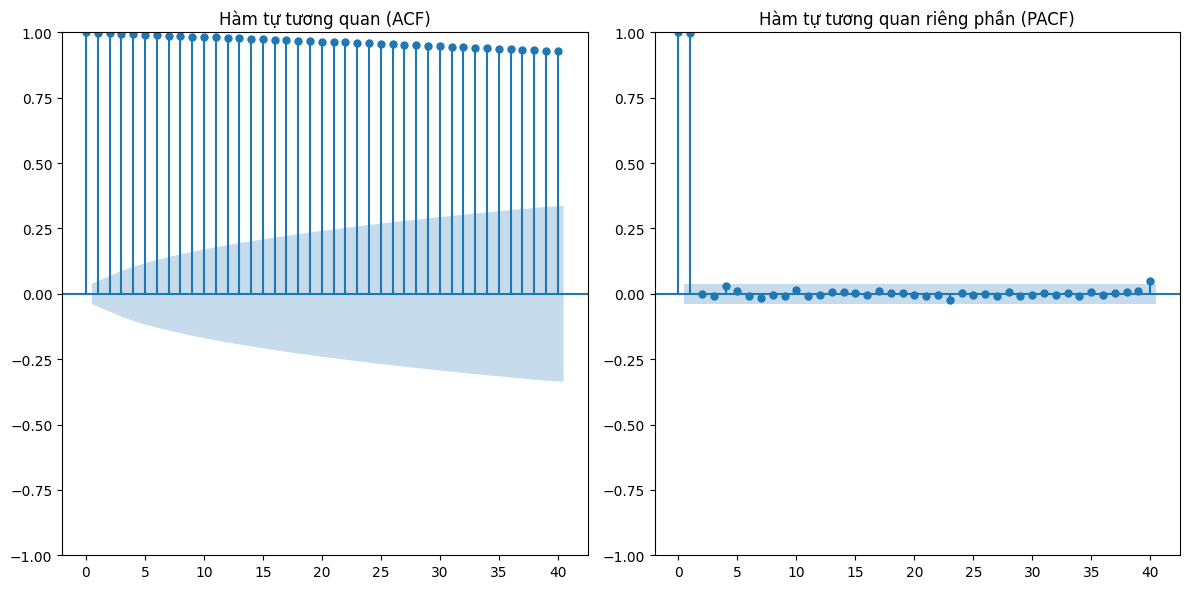

In [872]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Vẽ biểu đồ ACF và PACF cho cột 'close'
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ ACF (Tự tương quan)
plt.subplot(1, 2, 1)
plot_acf(VCB['close'], lags=40, ax=plt.gca())
plt.title('Hàm tự tương quan (ACF)')

# Vẽ biểu đồ PACF (Tự tương quan riêng phần)
plt.subplot(1, 2, 2)
plot_pacf(VCB['close'], lags=40, ax=plt.gca(), method='ywm')
plt.title('Hàm tự tương quan riêng phần (PACF)')

plt.tight_layout()
plt.show()


In [873]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go


fig = make_subplots(rows=5, cols=1,
                    subplot_titles=("Opening Price", "Closing Price", "Highest Price",
                                    "Lowest Price", "Volume"))

fig.add_trace(go.Scatter(x=VCB['date'], y=VCB["open"]), row=1, col=1)
fig.add_trace(go.Scatter(x=VCB['date'], y=VCB["close"]), row=2, col=1)
fig.add_trace(go.Scatter(x=VCB['date'], y=VCB["high"]), row=3, col=1)
fig.add_trace(go.Scatter(x=VCB['date'], y=VCB["low"]), row=4, col=1)
fig.add_trace(go.Scatter(x=VCB['date'], y=VCB["volume"]), row=5, col=1)

fig.update_layout(showlegend=False, height=1200, width=800)
              
fig.show()

In [874]:
import plotly.graph_objs as go


# Tạo biểu đồ
fig = go.Figure()

# Thêm trace cho VCB
fig.add_trace(go.Scatter(x=VCB['date'], y=VCB['close'], mode='lines', name='VCB'))

# Cập nhật layout của biểu đồ
fig.update_layout(
    title='Biểu Đồ Giá Đóng Cửa Cổ Phiếu VCB Theo Thời Gian',
    xaxis_title='Thời gian',
    yaxis_title='Giá Đóng Cửa (VND)'
)

# Hiển thị biểu đồ
fig.show()


In [875]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots



# Tạo biểu đồ con
fig = make_subplots(rows=1, cols=1, subplot_titles=["VCB"], vertical_spacing=0.08, horizontal_spacing=0.05)

# Thêm trace cho VCB
fig.add_trace(go.Scatter(x=VCB['date'], y=VCB['volume'], mode='lines', name='VCB'), row=1, col=1)

# Cập nhật layout của biểu đồ
fig.update_layout(
    height=800,  # Chiều cao của biểu đồ
    width=1000,  # Chiều rộng của biểu đồ
    title_text="Biểu Đồ Khối Lượng Giao Dịch Cổ Phiếu VCB Theo Thời Gian",
    xaxis_title='Thời gian',
    yaxis_title='Khối Lượng Giao Dịch'
)

# Hiển thị biểu đồ
fig.show()


**Mức độ tương quan giữa các thuộc tính**

In [876]:
# Tạo ma trận tương quan
correlation_matrix = VCB[['open', 'high', 'low', 'close', 'volume']].corr()

print("Ma trận tương quan giữa các biến:")
print(correlation_matrix)

Ma trận tương quan giữa các biến:
            open      high       low     close    volume
open    1.000000  0.999642  0.999712  0.999394  0.098891
high    0.999642  1.000000  0.999556  0.999738  0.106589
low     0.999712  0.999556  1.000000  0.999633  0.094377
close   0.999394  0.999738  0.999633  1.000000  0.101802
volume  0.098891  0.106589  0.094377  0.101802  1.000000


In [877]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np

# Giả sử df là DataFrame chứa các cột: low, high, open, close, nmVolume
# df = VCB[['low', 'high', 'open', 'close', 'nmVolume']]  # ví dụ nếu dùng từ dữ liệu VCB

cols = ['low', 'high', 'open', 'close', 'volume']
pval_matrix = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)

# Tính p-value cho từng cặp biến
for i in range(len(cols)):
    for j in range(len(cols)):
        if i == j:
            pval_matrix.iloc[i, j] = np.nan
        else:
            _, pval = pearsonr(df[cols[i]], df[cols[j]])
            pval_matrix.iloc[i, j] = round(pval, 4)

print("P-value Matrix:")
print(pval_matrix)


P-value Matrix:
        low  high  open  close  volume
low     NaN   0.0   0.0    0.0     0.0
high    0.0   NaN   0.0    0.0     0.0
open    0.0   0.0   NaN    0.0     0.0
close   0.0   0.0   0.0    NaN     0.0
volume  0.0   0.0   0.0    0.0     NaN


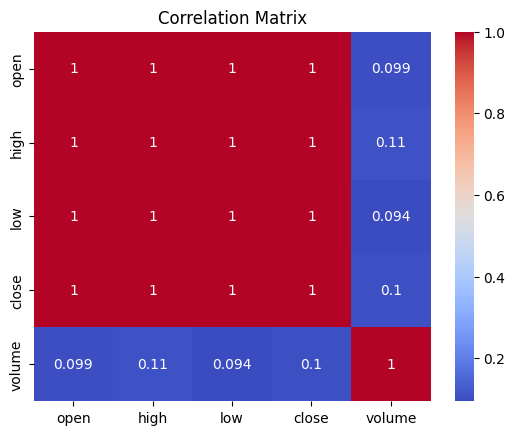

In [878]:
import seaborn as sns
import matplotlib.pyplot as plt

df = VCB[['open', 'high', 'low','close','volume']]
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# **Dùng mô hình  dự đoán**

## **I. Linear**

### *Import và xây dựng mô hình linearRegresstion*

In [879]:
import numpy as np

def mean_squared_error_custom(y_true, y_pred):
    """
    Tính Mean Squared Error (MSE) dựa trên các giá trị thực tế và dự đoán.
    
    Parameters:
    y_true (array-like): Mảng chứa các giá trị thực tế.
    y_pred (array-like): Mảng chứa các giá trị dự đoán.

    Returns:
    float: Giá trị MSE.
    """
    return np.mean((y_true - y_pred)**2)

def r2_score_custom(y_true, y_pred):
    """
    Tính R-squared Score dựa trên các giá trị thực tế và dự đoán.
    
    Parameters:
    y_true (array-like): Mảng chứa các giá trị thực tế.
    y_pred (array-like): Mảng chứa các giá trị dự đoán.

    Returns:
    float: Giá trị R-squared Score.
    """
    mean_y_true = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y_true)**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

def mean_absolute_error_custom(y_true, y_pred):
    """
    Tính Mean Absolute Error (MAE) dựa trên các giá trị thực tế và dự đoán.
    
    Parameters:
    y_true (array-like): Mảng chứa các giá trị thực tế.
    y_pred (array-like): Mảng chứa các giá trị dự đoán.

    Returns:
    float: Giá trị MAE.
    """
    return np.mean(np.abs(y_true - y_pred))


In [880]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

Đọc dữ liệu

In [881]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

In [882]:

df = VCB.copy()
# copy dataframe để thực hiện phần khác mà không làm thay đổi dữ liệu gốc
df1 = df.copy()
df['date'] = pd.to_datetime(df['date'])
features = ['open', 'high', 'low', 'volume']
X = df[features]
y = df['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20276\101478426.py:4: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



Tạo và huấn luyện mô hình Linear Regression

In [883]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [884]:
# Dự đoán giá với tập kiểm tra
y_pred = model_lr.predict(X_test)
y_pred


array([11354.98713484, 85402.92572764, 89360.94906981, 22210.08950118,
       25175.73374835, 60094.35699559, 58368.46181011, 36189.93513183,
       67079.05360626, 23186.66959651, 80491.67640336, 42695.70596339,
       20801.51360076, 39093.57556858, 33064.48316867, 62882.1471148 ,
       79850.38300819, 37342.62669504, 37893.57951896, 19376.69135305,
       67148.01219334, 95832.33651979, 39945.11486617, 23226.11586472,
       81938.62438821, 11497.08942962, 42286.00663766, 40092.76937599,
       17066.69129929, 65845.84485941, 74791.30613484, 56724.05051324,
       77688.04822323, 71873.40876239, 17536.22750213, 99205.57454978,
       71993.4068337 , 22670.40780931, 90400.21066679, 54717.93950468,
       20108.49501401, 54292.36346066, 46013.30082054, 42509.14171589,
       18685.43839271, 23199.68343758, 62893.88429711, 21922.13453337,
       50541.66980721, 69036.74098436, 50366.86451244, 39251.13050553,
       72623.24555827, 90113.48161502, 65896.94107617, 58248.67491884,
      

Trực quan dữ liệu thực tế với dữ liệu dự đoán bằng dataframe

In [885]:
dfr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dfr

,Actual,Predicted
53,11420,11354.987135
2391,85200,85402.925728
2310,89000,89360.949070
728,22340,22210.089501
850,25240,25175.733748
...,...,...
1810,65290,64726.167923
2330,89100,89191.677030
684,24110,24127.965563
1674,67220,67229.097291


Trực quan hóa bằng matplotlib

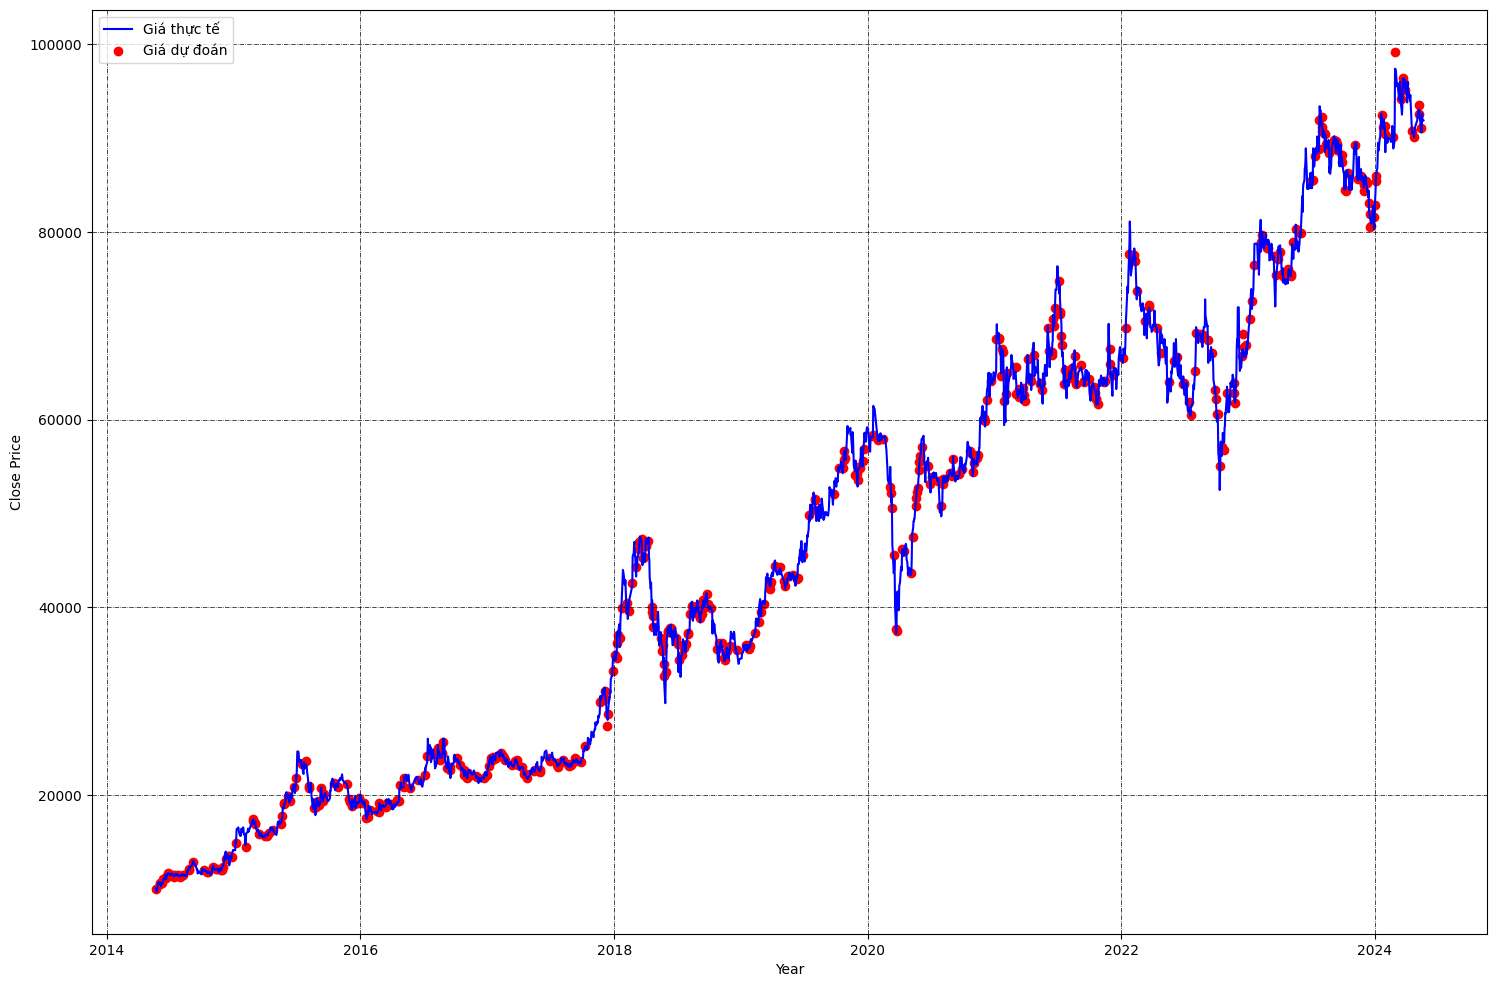

In [886]:
# Vẽ biểu đồ so sánh giữa giá thực tế và giá dự đoán
plt.figure(figsize=(18, 12))
plt.plot(df['date'], df['close'], label='Giá thực tế', color='blue')
plt.scatter(df['date'].iloc[X_test.index], y_pred,
            color='red', label='Giá dự đoán')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [903]:
# Đánh giá mô hình
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)


print(f'Mean Squared Error: {mse_lr}')
print(f'R^2 Score: {r2_lr}')
print("Mean Absolute Error (MAE):", mae_lr)


Mean Squared Error: 203776.62030259217
R^2 Score: 0.9996587459265965
Mean Absolute Error (MAE): 311.80289379090357


Tạo các cột 5 ngày tiếp theo kể từ dữ liệu cuối

In [887]:
for i in range(1,6):
    df[f'next_{i}_day'] = df['date'] + pd.Timedelta(days=i)

Dự đoán giá close cho 5 ngày tiếp theo kể từ dữ liệu cuối

In [888]:
# Tạo các giá trị mới cho 5 ngày tiếp theo
last_known_values = df1.iloc[-1][['open', 'high', 'low', 'volume', 'close']].values

# Tạo DataFrame để chứa các giá trị dự đoán
future_predictions = []

for i in range(5):
    # Tạo bộ dữ liệu mới dựa trên các giá trị đã biết gần nhất
    new_features = last_known_values[-6:-1]  # Sử dụng các đặc trưng `open`, `high`, `low`, `volume`
    new_features_df = pd.DataFrame([new_features], columns=features)
    
    # Dự đoán giá đóng cửa cho ngày mới
    predicted_price = model_lr.predict(new_features_df)[0]
    
    # Thêm giá trị dự đoán vào danh sách kết quả
    future_predictions.append(predicted_price)
    
    # Cập nhật các giá trị đã biết để dự đoán cho ngày tiếp theo
    last_known_values = np.append(last_known_values[1:], predicted_price)

print("Dự đoán giá đóng cửa cho 5 ngày tiếp theo:")
for i in range(1, 6):
    df[f'next_{i}_day'] = df['date'] + pd.Timedelta(days=i)
    df[f'next_{i}_day'] = pd.to_datetime(df[f'next_{i}_day'])
five_days_tail = []
five_pred_tail = []

# Kết hợp in ra các giá trị dự đoán với ngày tương ứng
for i, price in enumerate(future_predictions):
    next_day = df[f'next_{i+1}_day'].tail(1).dt.strftime('%Y-%m-%d').tolist()
    next_day_str = str(next_day[0])
    five_days_tail.append(next_day_str)
    # five_days_tail = df['time'].tail(1).dt.strftime('%Y-%m-%d').tolist()
    five_pred_tail.append(round(price,2))
    print(f"Ngày {i+1} ({next_day_str}): {price}")

Dự đoán giá đóng cửa cho 5 ngày tiếp theo:
Ngày 1 (2024-05-21): 92449.39484606919
Ngày 2 (2024-05-22): 719730.9045975573
Ngày 3 (2024-05-23): 847192.1478963103
Ngày 4 (2024-05-24): -340024.4250065616
Ngày 5 (2024-05-25): 506775.6629293012


Giá close dự đoán được 5 ngày kể từ dữ liệu cuối

In [889]:
df_five_tail = pd.DataFrame({'Time': five_days_tail, 'Predicted Price': five_pred_tail})
df_five_tail

,Time,Predicted Price
0,2024-05-21,92449.39
1,2024-05-22,719730.90
2,2024-05-23,847192.15
3,2024-05-24,-340024.43
4,2024-05-25,506775.66


10 ngày cuối của bảng dữ liệu dùng để quan sát với giá dự đoán 5 ngày tiếp theo phía trên

In [890]:
dtaa = df1[['date', 'close']]
dtaa.tail(10)

,date,close
2489,07-05-2024,92900
2490,08-05-2024,93000
2491,09-05-2024,92500
2492,10-05-2024,92000
2493,13-05-2024,91000
2494,14-05-2024,90600
2495,15-05-2024,91000
2496,16-05-2024,92600
2497,17-05-2024,91800
2498,20-05-2024,91900


Trực quan giá dự đoán 5 ngày


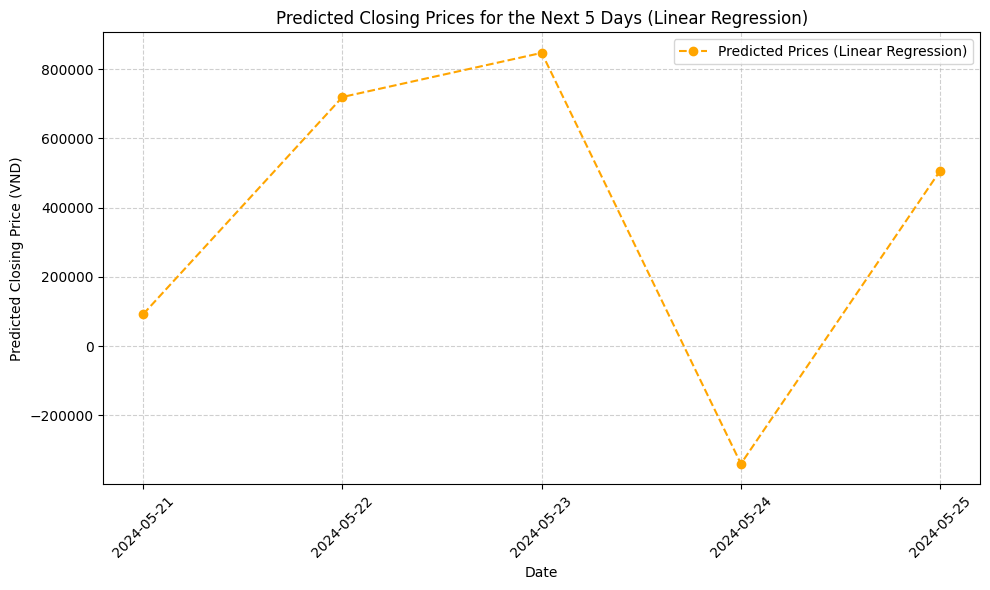

In [892]:
import matplotlib.pyplot as plt

# Extract the last 5 days and their predicted prices
predicted_days = five_days_tail
predicted_prices = five_pred_tail

# Plot the predicted prices
plt.figure(figsize=(10, 6))
plt.plot(predicted_days, predicted_prices, marker='o', linestyle='--', color='orange', label='Predicted Prices (Linear Regression)')
plt.title('Predicted Closing Prices for the Next 5 Days (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Predicted Closing Price (VND)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **II.LSTM**

### *import thư viện*

In [893]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.graph_objects as go



In [894]:
df =VCB.copy()
df

,Unnamed: 0,date,open,high,low,close,volume,ticker
0,0,20-05-2014,9960,10100,9770,10070,280870,VCB
1,1,21-05-2014,10100,10100,9920,10030,289340,VCB
2,2,22-05-2014,10030,10070,9960,9960,463230,VCB
3,3,23-05-2014,9960,9960,9700,9700,493560,VCB
4,4,26-05-2014,9810,10070,9700,10070,319920,VCB
...,...,...,...,...,...,...,...,...
2494,2494,14-05-2024,91100,91600,90500,90600,818400,VCB
2495,2495,15-05-2024,91000,91300,90800,91000,883100,VCB
2496,2496,16-05-2024,92000,92700,91500,92600,1713900,VCB
2497,2497,17-05-2024,92600,92600,91700,91800,1084700,VCB


In [895]:
train_data = pd.DataFrame(df, columns=['date', 'close'])

# Chuyển đổi dữ liệu thành mảng  và chuẩn hóa
train_data_values = train_data['close'].values.reshape(-1, 1)
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(train_data_values)

# Dùng 50 ngày liên tục làm cơ sở dự đoán của ngày tiếp theo
x_train, y_train, times = [], [], []
for i in range(50, len(train_data_values)):
    x_train.append(sc_train[i-50:i, 0])
    y_train.append(sc_train[i, 0])
    times.append(train_data['date'].values[i])

# Chuyển đổi dữ liệu thành mảng numpy
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape dữ liệu
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Xây dựng mô hình LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True))
model_lstm.add(LSTM(units=64))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_absolute_error', optimizer='adam')
model_lstm.fit(x_train, y_train, epochs=10, batch_size=50, verbose=2)

# Dự đoán trên tập huấn luyện
y_train_predict = model_lstm.predict(x_train)
y_train = sc.inverse_transform(y_train)
y_train_predict = sc.inverse_transform(y_train_predict)

Epoch 1/10


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



49/49 - 3s - 67ms/step - loss: 0.0884
Epoch 2/10
49/49 - 1s - 29ms/step - loss: 0.0534
Epoch 3/10
49/49 - 1s - 30ms/step - loss: 0.0492
Epoch 4/10
49/49 - 1s - 30ms/step - loss: 0.0463
Epoch 5/10
49/49 - 2s - 32ms/step - loss: 0.0446
Epoch 6/10
49/49 - 1s - 30ms/step - loss: 0.0437
Epoch 7/10
49/49 - 1s - 30ms/step - loss: 0.0436
Epoch 8/10
49/49 - 1s - 31ms/step - loss: 0.0406
Epoch 9/10
49/49 - 3s - 58ms/step - loss: 0.0391
Epoch 10/10
49/49 - 2s - 34ms/step - loss: 0.0402
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [904]:
y_train_predict

array([[11618.956],
       [11605.637],
       [11587.103],
       ...,
       [90316.75 ],
       [90263.52 ],
       [90225.96 ]], shape=(2449, 1), dtype=float32)

In [896]:
import plotly.graph_objects as go

# Thêm thời gian cho 5 ngày tiếp theo vào danh sách thời gian


# Vẽ biểu đồ so sánh giá thực và giá dự đoán trên tập dữ liệu huấn luyện bằng Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['date'], y=np.append(y_train.flatten(), np.nan * np.ones(5)), mode='lines', name='Giá thực', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=times, y=y_train_predict.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='red')))

fig.update_layout(
    title='So sánh giá thực và giá dự đoán trên tập dữ liệu huấn luyện',
    xaxis_title='Thời gian',
    yaxis_title='Giá đóng cửa',
    legend=dict(x=0, y=1, traceorder='normal')
)

fig.show()

In [906]:
# Đánh giá mô hình LSTM
mse_lstm = mean_squared_error(y_train, y_train_predict)
r2_lstm = r2_score(y_train, y_train_predict)
mae_lstm = mean_absolute_error(y_train, y_train_predict)

print(f"Mean Squared Error (MSE) - LSTM: {mse_lstm}")
print(f"R^2 Score - LSTM: {r2_lstm}")
print(f"Mean Absolute Error (MAE) - LSTM: {mae_lstm}")

Mean Squared Error (MSE) - LSTM: 2719877.0344996057
R^2 Score - LSTM: 0.9951543153178654
Mean Absolute Error (MAE) - LSTM: 1124.1411354124136


In [898]:
# Dự đoán 5 ngày tiếp theo
future_days = 5
last_50_days = sc_train[-50:]  # Lấy 50 ngày cuối cùng trong tập huấn luyện
predicted_future = []

# Tạo bản sao của last_50_days để không ảnh hưởng đến dữ liệu gốc
current_input = last_50_days.copy()

for _ in range(future_days):
    # Dự đoán giá ngày tiếp theo
    current_input_reshaped = np.reshape(current_input, (1, current_input.shape[0], 1))
    next_day_prediction = model_lstm.predict(current_input_reshaped)
    
    # Chuyển đổi giá trị dự đoán về dạng gốc
    next_day_prediction_inversed = sc.inverse_transform(next_day_prediction)
    
    # Thêm giá trị dự đoán vào danh sách kết quả
    predicted_future.append(next_day_prediction_inversed[0, 0])
    
    # Thêm giá trị dự đoán vào current_input và loại bỏ giá trị đầu tiên
    current_input = np.append(current_input[1:], next_day_prediction, axis=0)

# Hiển thị giá dự đoán cho 5 ngày tiếp theo
predicted_future = np.array(predicted_future)
print("Dự đoán giá cho 5 ngày tiếp theo:", predicted_future)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Dự đoán giá cho 5 ngày tiếp theo: [90211.93 90082.04 89883.97 89644.19 89380.52]


In [899]:
from datetime import datetime, timedelta

# Convert the last element of times to a datetime object
last_date = pd.to_datetime(times[-1]).to_pydatetime()

# Create a list of dates for the next 5 days
future_times = []
for i in range(1, 6):
    next_date = last_date + timedelta(days=i)
    future_times.append(next_date)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20276\326575784.py:4: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [900]:
import plotly.graph_objects as go

# Thêm thời gian cho 5 ngày tiếp theo vào danh sách thời gian
all_times = np.append(times, future_times)

# Vẽ biểu đồ so sánh giá thực và giá dự đoán trên tập dữ liệu huấn luyện bằng Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=times, y=y_train_predict.flatten(), mode='lines', name='Dự đoán huấn luyện', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=all_times[-5:], y=predicted_future, mode='lines', name='Dự đoán tương lai', line=dict(color='orange')))



fig.update_layout(
    title='So sánh giá thực và giá dự đoán trên tập dữ liệu huấn luyện',
    xaxis_title='Thời gian',
    yaxis_title='Giá đóng cửa',
    legend=dict(x=0, y=1, traceorder='normal')
)

fig.show()





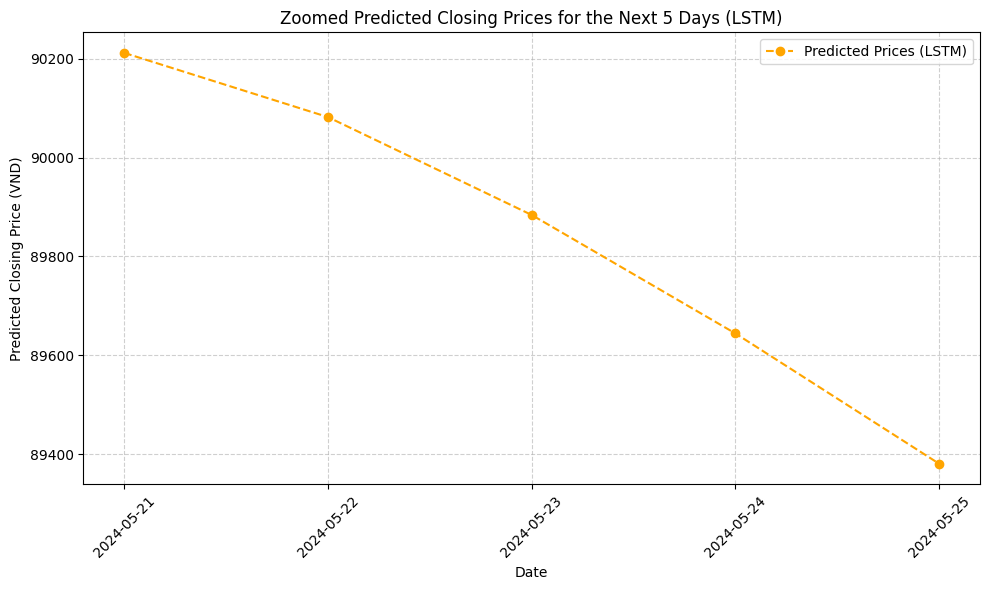

In [901]:
# Lấy dữ liệu dự đoán 5 ngày tiếp theo
predicted_days_zoom = five_days_tail
predicted_prices_zoom = predicted_future

# Vẽ biểu đồ phóng to vùng dự đoán 5 ngày
plt.figure(figsize=(10, 6))
plt.plot(predicted_days_zoom, predicted_prices_zoom, marker='o', linestyle='--', color='orange', label='Predicted Prices (LSTM)')
plt.title('Zoomed Predicted Closing Prices for the Next 5 Days (LSTM)')
plt.xlabel('Date')
plt.ylabel('Predicted Closing Price (VND)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **So sánh 2 phương pháp máy học đã dùng để dự đoán thị trường chứng khoán**

- Độ đo đánh giá giữa 2 mô hình:

In [902]:
metrics = {
    'Model': ['Linear Regression', 'LSTM'],
    'Mean Squared Error': [mse_lr, mse_lstm],
    'R^2 Score': [r2_lr, r2_lstm],
    'Mean Absolute Error (MAE)': [mae_lr, mae_lstm]
}

metrics_df = pd.DataFrame(metrics)

print(metrics_df)

               Model  Mean Squared Error  R^2 Score  Mean Absolute Error (MAE)
0  Linear Regression        2.037766e+05   0.999659                 311.802894
1               LSTM        2.719877e+06   0.995154                1124.141135
